In [5]:
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt
plt.style.use('Minh_paper_style')
from matplotlib.ticker import (FixedLocator, MultipleLocator, FixedFormatter, FormatStrFormatter,
                               AutoMinorLocator)
import nbodykit
from nbodykit.lab import *

## Check the data box

In [40]:
#cat_reformat='/cobra/u/minh/Beyond2ptMock/mock_lcdm_real-space_01_real_reformatted0.h5'
#cat_reformat='../LEFTFIELD_input/mock_lcdm_real-space_01_real_reformatted.h5'
cat_reformat='../LEFTFIELD_input/mock_lcdm_real-space_02_real_reformatted0.h5'

with h5.File(cat_reformat,'r') as fhandle:
    x = fhandle['x'][()] #each in units of comoving-Mpc/h
    y = fhandle['y'][()]
    z = fhandle['z'][()]
    print(fhandle.keys())
    
print(x.max())
print(y.max())
print(z.max())

<KeysViewHDF5 ['Mgal', 'x', 'y', 'z']>
1999.9994
1999.9998
1999.995


## Specify setup

## Read in original galaxy catalog and compute auto-power using nbodykit

In [80]:
cat=HDFCatalog(cat_reformat)
cat['Position']=x[:,None]*(1,0,0)+y[:,None]*(0,1,0)+z[:,None]*(0,0,1)
cat.attrs['BoxSize']=2000.
mesh_origin = cat.to_mesh(resampler='cic', Nmesh=512, compensated=True, interlaced=False, position='Position')
r_origin = FFTPower(mesh_origin, mode='1d', dk=0.005, kmin=0.005)
Pk_origin = r_origin.power
for k in Pk_origin.attrs:
    print("%s = %s" %(k, str(Pk_origin.attrs[k])))

Nmesh = [512 512 512]
BoxSize = [2000. 2000. 2000.]
Lx = 2000.0
Ly = 2000.0
Lz = 2000.0
volume = 8000000000.0
mode = 1d
los = [0, 0, 1]
Nmu = 1
poles = []
dk = 0.005
kmin = 0.005
kmax = None
N1 = 3591859
N2 = 3591859
shotnoise = 2227.2589207983942


In [86]:
NGLambda=90
L=cat.attrs['BoxSize']
eps=np.sqrt(Pk_origin.attrs['shotnoise']*((NGLambda/L)**3))
print(eps)

0.45050967709667866


## Read in lefty-input galaxy catalog and compute auto-power

In [82]:
cat_processed='../LEFTFIELD_input/mock_lcdm_real-space_01_real_NGEul512.h5'
Lbox=2000.
with h5.File(cat_processed, 'r') as fhandle:
    delta=fhandle['delta'][()]
    print(delta.shape)
mesh_leftfield = ArrayMesh(delta,BoxSize=Lbox)
r_leftfield = FFTPower(mesh_leftfield, mode='1d', dk=0.005, kmin=0.005)
Pk_leftfield = r_leftfield.power
for k in Pk_leftfield.attrs:
    print("%s = %s" %(k, str(Pk_leftfield.attrs[k])))

(512, 512, 512)
Nmesh = [512 512 512]
BoxSize = [2000. 2000. 2000.]
Lx = 2000.0
Ly = 2000.0
Lz = 2000.0
volume = 8000000000.0
mode = 1d
los = [0, 0, 1]
Nmu = 1
poles = []
dk = 0.005
kmin = 0.005
kmax = None
N1 = 0
N2 = 0
shotnoise = 0


In [83]:
cat_processed='../LEFTFIELD_input/mock_lcdm_real-space_01_real_NGEul512_NUFFT.h5'
Lbox=2000.
with h5.File(cat_processed, 'r') as fhandle:
    delta=fhandle['delta'][()]
    print(delta.shape)
mesh_leftfield = ArrayMesh(delta,BoxSize=Lbox)
r_leftfield_NUFFT = FFTPower(mesh_leftfield, mode='1d', dk=0.005, kmin=0.005)
Pk_leftfield_NUFFT = r_leftfield_NUFFT.power
for k in Pk_leftfield_NUFFT.attrs:
    print("%s = %s" %(k, str(Pk_leftfield_NUFFT.attrs[k])))

(512, 512, 512)
Nmesh = [512 512 512]
BoxSize = [2000. 2000. 2000.]
Lx = 2000.0
Ly = 2000.0
Lz = 2000.0
volume = 8000000000.0
mode = 1d
los = [0, 0, 1]
Nmu = 1
poles = []
dk = 0.005
kmin = 0.005
kmax = None
N1 = 0
N2 = 0
shotnoise = 0


In [ ]:
white_IC_file='../LEFTFIELD_input/beyond2pt_data_challenge/white_real-space_01_ng512.h5'
with h5.File(white_IC_file,'r') as fhandle:
    input_sfield=fhandle['delta'][()]
print(input_sfield.var())

input_shat=np.fft.fftn(input_sfield)
input_shat_hartley=input_shat.real-input_shat.imag
print(input_shat_hartley.shape)
print(input_shat_hartley.var()/(512**3))

In [ ]:
mesh_input = ArrayMesh(input_sfield,BoxSize=Lbox)
r_input = FFTPower(mesh_input, mode='1d', dk=0.01, kmin=0.005)
Pk_input = r_input.power
for k in Pk_input.attrs:
    print("%s = %s" %(k, str(Pk_input.attrs[k])))

In [ ]:
plt.loglog(Pk_input['k'],Pk_input['power'])
plt.ylabel(r'$P_{\hat{s}\hat{s}}(k)$')
plt.xlabel(r'$k$')

## Get $P_{\mathrm{lin}}$ from CAMB to compare with the other two

In [65]:
redshift = 1.0
h=0.676225
Omega0_m=0.310240
Omega0_b=0.0222554/(h**2)
Omega0_ncdm=0.00064420/(h**2)
Omega0_cdm=Omega0_m-Omega0_b-Omega0_ncdm
A_s=1.6956555e-09
n_s=0.991533
#cosmo = cosmology.Cosmology(h=h,Omega0_cdm=Omega0_cdm,Omega0_b=Omega0_b,A_s=A_s,n_s=n_s,N_ncdm=1.0,m_ncdm=[0.06],N_ur=2.0328,nonlinear='halofit')
cosmo = cosmology.Cosmology(h=h,Omega0_cdm=Omega0_cdm,Omega0_b=Omega0_b,A_s=A_s,n_s=n_s,nonlinear='halofit')
cosmo_nomass_neutrino = cosmology.Cosmology(h=h,Omega0_cdm=Omega0_cdm,Omega0_b=Omega0_b,A_s=A_s,n_s=n_s,N_ncdm=1.0,m_ncdm=None,N_ur=2.0328,nonlinear='halofit')
Plin_CLASS = cosmology.LinearPower(cosmo, redshift, transfer='CLASS')
Plin_CLASS_nomass_neutrino=cosmology.LinearPower(cosmo_nomass_neutrino, redshift, transfer='CLASS')
Pnonlin_Zeldovich = cosmology.ZeldovichPower(cosmo, redshift)
Pnonlin_HALOFIT = cosmology.HalofitPower(cosmo, redshift)

/u/minh/conda-envs/jupyterlab-env/lib/python3.6/site-packages/mcfit/mcfit.py:126: UserWarning: The default value of lowring has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of lowring has been changed to False, "


In [66]:
print(Plin_CLASS_nomass_neutrino.sigma8)
print(Plin_CLASS.sigma8)

0.809605831073408
0.7334745943987481


## Plot power spectra

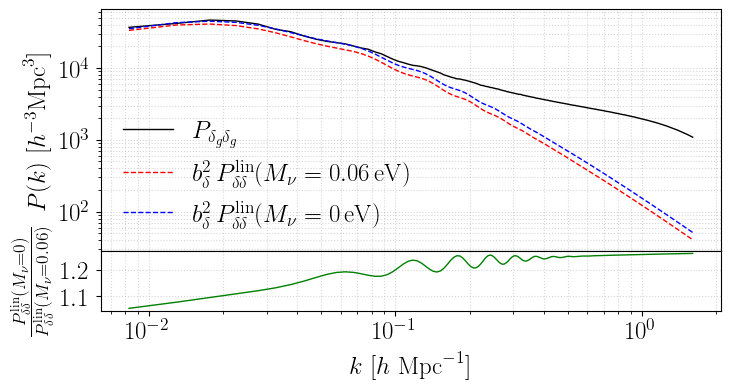

In [77]:
# print the shot noise subtracted P(k)
fig, ax = plt.subplots(2, sharex=True, sharey=False, gridspec_kw={'hspace': 0., 'wspace':0., 'height_ratios':[8, 2]}, figsize=(8, 4))

bdelta_fid=2.4015120568065296
#ax.loglog(Pk_origin['k'], (Pk_origin['power'].real), c='b',label=r'$P_{gg}$, CIC-deconvolved')
#ax.loglog(Pk_leftfield['k'],Pk_leftfield['power'].real,c='r',ls='--',label=r'$P_{gg}$ leftfield CIC')
ax[0].loglog(Pk_leftfield_NUFFT['k'],Pk_leftfield_NUFFT['power'].real,c='k',ls='-',label=r'$P_{\delta_g\delta_g}$')
ax[0].loglog(Pk_origin['k'],(bdelta_fid**2)*Plin_CLASS(Pk_origin['k']),c='r',ls='--',label=r'$b_{\delta}^2\,P^{\mathrm{lin}}_{\delta\delta}(M_\nu=0.06\,\mathrm{eV})$')
ax[0].loglog(Pk_origin['k'],(bdelta_fid**2)*Plin_CLASS_nomass_neutrino(Pk_origin['k']),c='b',ls='--',label=r'$b_{\delta}^2\,P^{\mathrm{lin}}_{\delta\delta}(M_\nu=0\,\mathrm{eV})$')
#ax.loglog(k_CLASS,(bdelta_fid**2)*Plin_CLASS,c='k',ls=':',label=r'$b_1^2\,P^{\mathrm{linear}}_{mm}$ baseline-cosmo')
ax[0].grid(True, which="both", ls=":",alpha=0.5)
# format the axes
ax[0].legend()
ax[0].set_ylabel(r"$P(k)$ [$h^{-3}\mathrm{Mpc}^3$]")
ax[1].semilogx(Pk_origin['k'],Plin_CLASS_nomass_neutrino(Pk_origin['k'])/Plin_CLASS(Pk_origin['k']),color='g')
#ax[1].yaxis.tick_right()
#ax[1].fill_between(k,y1=-0.001,y2=0.001,color='silver',alpha=0.5)
ax[1].grid(True,which="both",ls=':',alpha=0.5)
ax[1].set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
ax[1].set_ylabel(r"$\frac{P^{\mathrm{lin}}_{\delta\delta}(M_\nu=0)}{P^{\mathrm{lin}}_{\delta\delta}(M_\nu=0.06)}$")
#plt.xlim(0.01, 0.6)
#ax.set_ylim(1E3,6E4)
ax[0].set_facecolor('white')
ax[1].set_facecolor('white')

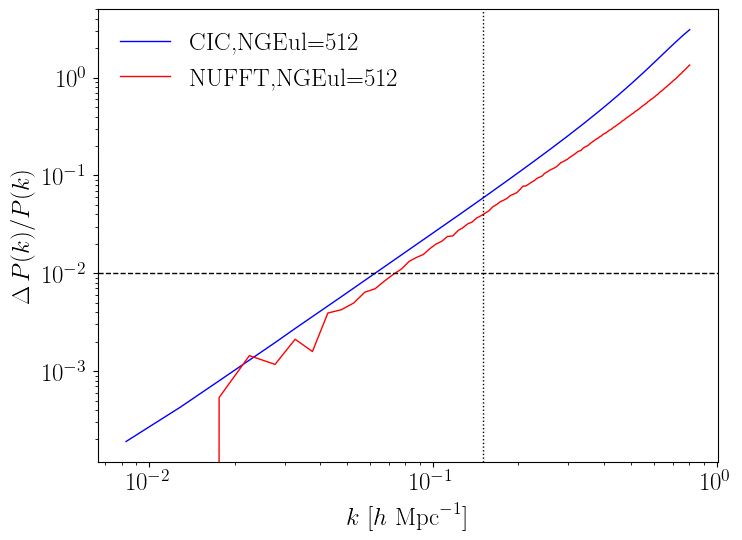

In [84]:
fig,ax=plt.subplots()

ax.loglog(Pk_origin['k'], (Pk_origin['power'].real-Pk_leftfield['power'].real)/Pk_leftfield['power'].real, c='b',label=r'CIC,NGEul=512')
ax.loglog(Pk_origin['k'], (Pk_origin['power'].real-Pk_leftfield_NUFFT['power'].real)/Pk_leftfield_NUFFT['power'].real, c='r',label=r'NUFFT,NGEul=512')


# format the axes
ax.legend()
ax.set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
ax.set_ylabel(r"$\Delta\,P(k)/P(k)$")
ax.axhline(y=1E-2,c='k',ls='--')
ax.axvline(x=1.5E-1,c='k',ls=':')
#plt.xlim(0.01, 0.6)
#ax.set_ylim(1E3,6E4)
ax.set_facecolor('white')

## Compute linear galaxy bias $b_1$

In [ ]:
np.sqrt(Pk_leftfield['power'].real[Pk_leftfield['k']<0.02]/Plin_CLASS(Pk_origin['k'][Pk_leftfield['k']<0.02]))